<a href="https://colab.research.google.com/github/FurqanBhat/ML-Colab-Notebooks/blob/main/RNN_scratch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!unzip ./data.zip

Archive:  ./data.zip
   creating: data/
  inflating: data/eng-fra.txt        
   creating: data/names/
  inflating: data/names/Arabic.txt   
  inflating: data/names/Chinese.txt  
  inflating: data/names/Czech.txt    
  inflating: data/names/Dutch.txt    
  inflating: data/names/English.txt  
  inflating: data/names/French.txt   
  inflating: data/names/German.txt   
  inflating: data/names/Greek.txt    
  inflating: data/names/Irish.txt    
  inflating: data/names/Italian.txt  
  inflating: data/names/Japanese.txt  
  inflating: data/names/Korean.txt   
  inflating: data/names/Polish.txt   
  inflating: data/names/Portuguese.txt  
  inflating: data/names/Russian.txt  
  inflating: data/names/Scottish.txt  
  inflating: data/names/Spanish.txt  
  inflating: data/names/Vietnamese.txt  


In [ ]:
import io
import os
import unicodedata
import string
import glob

import torch
import random

ALL_LETTERS=string.ascii_letters+".,;'"
N_LETTERS=len(ALL_LETTERS)

def unicode_to_ascii(s):
  return ''.join(
      c for c in unicodedata.normalize('NFD',s)
      if unicodedata.category(c) != 'Mn'
      and c in ALL_LETTERS
  )

def load_data():
  category_lines={}
  all_categories=[]

  def find_files(path):
    return glob.glob(path)

  def read_lines(filename):
    lines=io.open(filename,encoding='utf-8').read().strip().split('\n')
    return [unicode_to_ascii(line) for line in lines]

  for filename in find_files('./data/names/*.txt'):
    category=os.path.splitext(os.path.basename(filename))[0]
    all_categories.append(category)

    lines=read_lines(filename)
    category_lines[category]=lines

  return category_lines, all_categories


def letter_to_index(letter):
    return ALL_LETTERS.find(letter)


def letter_to_tensor(letter):
    tensor=torch.zeros(1,N_LETTERS)
    tensor[0][letter_to_index(letter)]=1
    return tensor



def line_to_tensor(line):
    tensor=torch.zeros(len(line),1,N_LETTERS)
    for i, letter in enumerate(line):
      tensor[i][0][letter_to_index(letter)]=1

    return tensor

def random_training_example(category_lines, all_categories):

      def random_choice(a):
        random_idx=random.randint(0,len(a)-1)
        return a[random_idx]


      category=random.choice(all_categories)
      line=random_choice(category_lines[category])
      category_tensor=torch.tensor([all_categories.index(category)], dtype=torch.long)
      line_tensor=line_to_tensor(line)
      return category, line, category_tensor, line_tensor




In [ ]:
import torch
import torch.nn as nn
import matplotlib.pyplot as plt


In [ ]:
class RNN(nn.Module):
  def __init__(self, input_size, hidden_size, output_size):
    super(RNN, self).__init__()

    self.hidden_size=hidden_size
    self.i2h=nn.Linear(input_size + hidden_size, hidden_size)
    self.i2o=nn.Linear(input_size+hidden_size, output_size)
    self.softmax=nn.Softmax(dim=1)


  def forward(self, input_tensor, hidden_tensor):
    combined=torch.cat((input_tensor, hidden_tensor), 1)
    hidden=self.i2h(combined)
    output=self.i2o(combined)
    output=self.softmax(output)
    return output, hidden


  def init_hidden(self):
    return torch.zeros(1, self.hidden_size)

In [ ]:
category_lines, all_categories= load_data()
n_categories=len(all_categories)

In [ ]:
n_hidden=128
rnn=RNN(N_LETTERS, n_hidden, n_categories)

input_tensor=letter_to_tensor('A')
hidden_tensor=rnn.init_hidden()

output, next_hidden=rnn(input_tensor, hidden_tensor)
# print(output.shape)
# print(next_hidden.shape)

input_tensor=line_to_tensor("hello")
hidden_tensor=rnn.init_hidden()

output, next_hidden=rnn(input_tensor[0], hidden_tensor)
# print(output.shape)
# print(next_hidden.shape)

def category_from_output(output):
  category_idx=torch.argmax(output).item()
  return all_categories[category_idx]


print(category_from_output(output))

German


In [ ]:
criterion=nn.NLLLoss()
learning_rate=0.005
optimizer=torch.optim.SGD(rnn.parameters(), lr=learning_rate)

In [ ]:
def train(line_tensor, category_tensor):
  hidden=rnn.init_hidden()
  for i in range(line_tensor.size()[0]):
    output, hidden=rnn(line_tensor[i], hidden)

  loss=criterion(output, category_tensor)
  loss.backward()

  optimizer.step()
  optimizer.zero_grad()

  return output, loss.item()




4999 4.999, -0.9434, She / Chinese CORRECT
9999 9.998999999999999, -0.0002, Lis / Chinese WRONG (Polish)
14999 14.999, -0.0095, Reijnders / Russian WRONG (Dutch)
19999 19.999, -0.3724, O'Brian / Irish CORRECT
24999 24.999, -0.1517, Santana / Italian WRONG (Portuguese)
29999 29.999, -0.0004, Guttridge / Russian WRONG (English)
34999 34.999, -0.0010, Picasso / Polish WRONG (Spanish)
39999 39.999, -0.5259, Ventura / Portuguese CORRECT
44999 44.999, -0.7315, Moy / Chinese CORRECT
49999 49.999, -0.0812, Quinn / Chinese WRONG (Irish)
54999 54.998999999999995, -0.0032, Small / Japanese WRONG (English)
59999 59.999, -0.0044, Nemec / German WRONG (Czech)
64999 64.999, -0.0002, Gutierrez / German WRONG (Spanish)
69999 69.999, -0.3504, Medeiros / Greek WRONG (Portuguese)
74999 74.99900000000001, -0.0012, Almasi / Italian WRONG (Arabic)
79999 79.999, -0.0005, Schorel / Portuguese WRONG (Dutch)
84999 84.999, -0.0027, Ochiai / Irish WRONG (Japanese)
89999 89.999, -0.3033, Hadjiyianakies / Japanese W

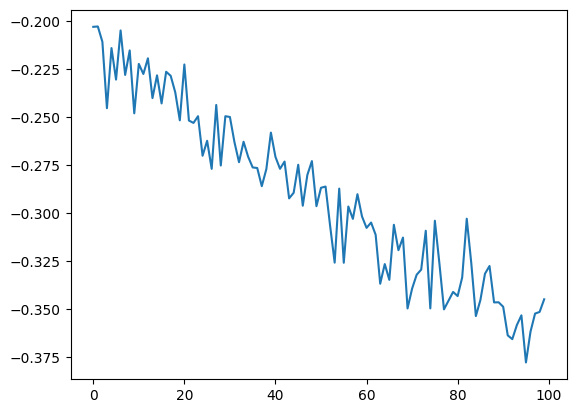

In [ ]:
curr_loss=0
all_losses=[]

plot_steps, print_steps=1000,5000
n_iters=100000
for i in range(n_iters):
  category, line, category_tensor, line_tensor=random_training_example(category_lines, all_categories)
  output, loss=train(line_tensor, category_tensor)
  curr_loss+=loss
  if (i+1)%plot_steps==0:
    all_losses.append(curr_loss/plot_steps)
    curr_loss=0

  if (i+1)%print_steps==0:
    guess=category_from_output(output)
    correct="CORRECT" if guess==category else f"WRONG ({category})"
    print(f'{i} {i/n_iters*100}, {loss:.4f}, {line} / {guess} {correct}')



plt.figure()
plt.plot(all_losses)
plt.show()

def predict(input_line):
  print(f"\n{input_line}")
  with torch.no_grad():
    line_tensor=line_to_tensor(input_line)
    hidden=rnn.init_hidden()
    for i in range(line_tensor.size()[0]):
      output, hidden=rnn(line_to_tensor[i], hidden)

    guess=category_from_output(output)
    print(guess)

while(True):
  sentence=input("Input:")
  if(sentence=='quit'):
    break

  predict(sentence)
